# Goal: Implement MCR Analysis on Pd20Au80 spectra for MES


## Package Dependency: pyMCR 

Source: https://pages.nist.gov/pyMCR/ <br>
Paper: https://nvlpubs.nist.gov/nistpubs/jres/124/jres.124.018.pdf

Other good references:
1. https://www.cid.csic.es/homes/rtaqam/tmp/WEB_MCR/download/pdf/MCR_2005.pdf

### Background: Multivariate curve resolution (MCR)

MCR
- also known as self-modeling mixture analysis (SMMA)
- is a chemometric method for analyzing data from mixtures, extracting relative abundances and signature of pure analytes. [Endmember extraction]
- In the context of MCR to extract spectra and relative concentration from series of chemical mixture is referred to as **"spectral unmixing"**

$D$: Series of mixture measurement of dimension [$m\times n$] <br>
$m$: Number of independent measurments <br>
$n$: Number of elements for a single measurement (e.g. spectral frequency bins) <br>

$$D = CS^T + \epsilon$$

$C$: Concentration matrix of dimension [$m\times p$] <br>
$m$: Number of independent measurments <br>
$p$: Number of species (analytes) <br>

$S$: Signautre (or spectra) of $p$ analytes <br>
$\epsilon$: Noise, error, or aspects not captured by the model

### Solver

Iterative alternating regression (AR) scheme

Why is it called alternating?
- It updates the values of $C$ and $S^T$ alternately.

### Important Logistical Notes on MCR

MCR Method requires an initial guess for either C or S. Various strategies exist such as:
- random guess
- matrix decomposition
- expert input

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from import_all import *

In [2]:
import sys
import logging

import seaborn as sns
sns.set_theme(context = 'notebook',
              style = 'ticks',
              palette = 'Set1'
                 )


import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 100
import numpy as np
import pandas as pd



# importing pymcr pieces
from pymcr.mcr import McrAR
from pymcr.regressors import OLS, NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm, ConstraintZeroCumSumEndPoints

from sklearn.linear_model import Ridge

#Object Oriented Imports
from dataclasses import dataclass
from typing import List
from scipy.sparse.linalg import svds
from sklearn.decomposition import PCA


from sklearn.preprocessing import MinMaxScaler

In [3]:
import dataclasses
from dataclasses import field

In [4]:
import pymcr

In [5]:
dir(pymcr.regressors)

['LinearRegression',
 'NNLS',
 'OLS',
 '_ABC',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_abstractmethod',
 '_lstsq',
 '_nnls',
 '_np']

## Set logger

In [6]:
logger  = logging.getLogger('pymcr')

logger.setLevel(logging.DEBUG)

stdout_handler = logging.StreamHandler(stream=sys.stdout)

stdout_format = logging.Formatter('%(message)s')
stdout_handler.setFormatter(stdout_format)

logger.addHandler(stdout_handler)

# MCR on XAS

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
@dataclass
class MCR_ALS():
    D: np.array
    fit_params: 'typing.Any' 
    exp_params: 'typing.Any' 
    initial_spectra: np.array = None
    initial_conc_map: np.array = None
   

    
    def initialize(self):
        if fit_params.NORMALIZE:
            self.D_scaler = StandardScaler().fit(X=self.D)
            #print(f"Min max normalization of Dataset \'D\' with {self.D_scaler.data_max_}")
            self.D_scaled = self.D_scaler.transform(self.D)
        
        if fit_params.SP_GUESS and fit_params.SP_GUESS_TYPE == 'RAND':
            np.random.seed(fit_params.RANDOM_STATE)
            self.initial_spectra = np.random.rand(self.exp_params.p, self.exp_params.n)
            print(f"Initial Guess of Spectra with Random numbers. Shape of guess{self.initial_spectra.shape}")

        elif fit_params.SP_GUESS and fit_params.SP_GUESS_TYPE == 'SVD':
            U, s, Vh = svds(self.D, k=self.exp_params.p+1)
            Vh = Vh[np.flip(np.argsort(s))[:-1],:]
            self.initial_spectra = np.abs(Vh)/Vh.max()*self.D.max() 
            print(f"Initial Guess of Spectra with SVD. Shape of guess{self.initial_spectra.shape}")

        elif fit_params.SP_GUESS and fit_params.SP_GUESS_TYPE == 'PCA':
            self._pca = PCA(self.exp_params.p)
            if fit_params.NORMALIZE:
                self._pca.fit(self.D_scaled)
                self.initial_spectra = self._pca.components_
                
            else:
                self._pca.fit(self.D)
                self.D_PrePCA = self.D    #saved original D matrix
                self.initial_spectra = self._pca.components_
                #self.initial_spectra = self._pca.transform(self.D)#.transpose()
            #init_scaler = MinMaxScaler().fit(X=self.initial_spectra.T)
            #self.initial_spectra = init_scaler.transform(self.initial_spectra.T).transpose()
            
        elif fit_params.CONC_GUESS:
            print('Guessing Concentration: Random')
            self.initial_conc_map = np.random.rand(self.exp_params.m, self.exp_params.p)
            print('Adding constraint of Sum to one in random guess')
            self.initial_conc_map = (self.initial_conc_map.T/(self.initial_conc_map.sum(axis=1)).T).T
            
        
    def process_MCR(self, constraints, verbose=True,
                    *args, **kwargs):
        self.mcrar = McrAR(max_iter=constraints.MAX_ITERATIONS, tol_increase=2,
                           c_regr=constraints.C_regressor,
                           st_regr=constraints.S_regressor,
                           c_constraints=constraints.C_constraints,
                           st_constraints=constraints.S_constraints, 
                           *args, **kwargs)
        
        if fit_params.SP_GUESS:
            self.mcrar.fit(self.D,
                                  ST = self.initial_spectra,
                                  verbose=verbose)
        if fit_params.CONC_GUESS:
            self.mcrar.fit(self.D,
                                  C=self.initial_conc_map,
                                  verbose=verbose)
        print('\nFinal MSE: {:.7e}'.format(self.mcrar.err[-1]))
        
        #return self.mcrar

    def visualize_initial_guesses(self):
        if fit_params.SP_GUESS:
            if fit_params.NORMALIZE and self.D_scaler is not None:
                #guess_spectra = self.D_scaler.inverse_transform(self.initial_spectra)
                guess_spectra = self.initial_spectra
            else:
                guess_spectra = self.initial_spectra
            _ = plt.figure()
            for i in range(self.exp_params.p):
                _ = sns.lineplot(x=list(range(self.exp_params.n)), y= guess_spectra[i,:] )
            plt.title(f'Spectra obtained by {fit_params.SP_GUESS_TYPE} ')
            _ = plt.show()
        else:
            self._visualize_concentration_maps(conc=self.initial_conc_map)
        
    def visualize_mcr_output(self, c_x=None, s_x=None):
        self._visualize_concentration_maps(conc=self.mcrar.C_opt_, x_axis=c_x)
        self._visualize_ST_opt_(x_axis=s_x)
    
    def _visualize_concentration_maps(self, conc, x_axis=None):
        if x_axis is None:
            x_axis = list(range(1,self.exp_params.m+1,1))
        _ = plt.figure()
        for i in range(self.exp_params.p):
            _ = sns.lineplot(x=x_axis, y = conc[:,i])
        _ = plt.title("Concentration map obtained by pyMCR")
        _ = plt.show()
        
    def _visualize_ST_opt_(self, x_axis=None):
        if x_axis is None:
            x_axis = list(range(self.exp_params.n))
        _ = plt.figure()
        for i in range(self.exp_params.p):
            ax = sns.lineplot(x=x_axis, y= self.mcrar.ST_opt_[i,:],)
        _ = ax.set_title('Spectra obtained by pyMCR')
        _ = plt.show()
    
    def compare_output(self):
        fig, ax = plt.subplots(1,2,figsize=(12,5))
        for i in range(self.exp_params.p):
            ax[0] = sns.lineplot(x=list(range(self.exp_params.n)), y= yang_S.iloc[i,:].values, ax=ax[0])
            ax[1] = sns.lineplot(x=list(range(self.exp_params.n)), y= self.mcrar.ST_opt_[i,:], ax=ax[1])
        _ = ax[0].set_title('Spectra obtained by MCR from Yang')
        _ = ax[1].set_title('Spectra obtained by pyMCR code from PKR')
        _ = plt.show()

    def visualize_data(self):
        raise Exception("Not Implemented Yet")
    
    def export_output(self):
        raise Exception("Not Implemented Yet")
        
        
if __name__=='__main__':
    pass
    #assert SP_GUESS is not CONC_GUESS

### Load Data

In [ ]:
!wget https://raw.githubusercontent.com/pkrouth/XAFS2023/main/data/mcr/NiClZnCl2.csv?token=GHSAT0AAAAAACIW3KGE7LFV26NBF7QIAHPYZJO4GSA -O NiClZnCl2.csv
!wget https://raw.githubusercontent.com/pkrouth/XAFS2023/main/data/mcr/NiClZnCl2copt.csv?token=GHSAT0AAAAAACIW3KGEK4F3YHB2ADRSWKOUZJO4JCQ -O NiClZnCl2copt.csv
!wget https://raw.githubusercontent.com/pkrouth/XAFS2023/main/data/mcr/NiClZnCl2sopt.csv?token=GHSAT0AAAAAACIW3KGEDWMNSWKH2ROUAN66ZJO4IHQ -O NiClZnCl2sopt.csv

In [9]:
data_D = pd.read_csv('./NiClZnCl2.csv',
                  header=None)

In [10]:
yang_C = pd.read_csv('./NiClZnCl2copt.csv',
                    header=None)

In [11]:
yang_S = pd.read_csv('./NiClZnCl2sopt.csv',
                    header=None)

In [12]:
D = data_D.values

In [13]:
D.shape, yang_C.shape, yang_S.shape

((6, 324), (6, 3), (3, 324))

### Define Guesses

### Set MCR Parameters

In [14]:
@dataclass
class McrConstraints:
    C_constraints: List = field(default_factory= lambda: [ConstraintNonneg(), ConstraintNorm()])
    S_constraints: List = field(default_factory= lambda: [ConstraintNonneg()])
    C_regressor: str = 'NNLS'
    S_regressor: str = 'NNLS'
    MAX_ITERATIONS: int = 2000

In [15]:
@dataclass
class FittingParams:
    NORMALIZE: bool = False
    SP_GUESS: bool = False
    CONC_GUESS: bool = field(init=False, repr=True)
    SP_GUESS_TYPE: str = 'SVD' # RAND, SVD, PCA
    RANDOM_STATE: int = 1200
    

    
    def __post_init__(self):
        self.CONC_GUESS = not self.SP_GUESS

In [16]:
@dataclass
class ExperimentParams:
    p: int # number of species
    m: int # number of measurements
    n: int # number of bins

### TO DO:

In [17]:
fit_constraints = McrConstraints()
fit_params = FittingParams(SP_GUESS=False)
# experiment_params = ExperimentParams(p=###, m=###, n=###)
experiment_params = ExperimentParams(p=3, m=6, n=324)

## Play

In [18]:
print(f'{fit_constraints = },\n {fit_params = },\n {experiment_params = }')

fit_constraints = McrConstraints(C_constraints=[<pymcr.constraints.ConstraintNonneg object at 0x19b9cf220>, <pymcr.constraints.ConstraintNorm object at 0x19b9cf430>], S_constraints=[<pymcr.constraints.ConstraintNonneg object at 0x19b9cfc70>], C_regressor='NNLS', S_regressor='NNLS', MAX_ITERATIONS=2000),
 fit_params = FittingParams(NORMALIZE=False, SP_GUESS=False, CONC_GUESS=True, SP_GUESS_TYPE='SVD', RANDOM_STATE=1200),
 experiment_params = ExperimentParams(p=3, m=6, n=324)


## Run MCR Analysis

Guessing Concentration: Random
Adding constraint of Sum to one in random guess


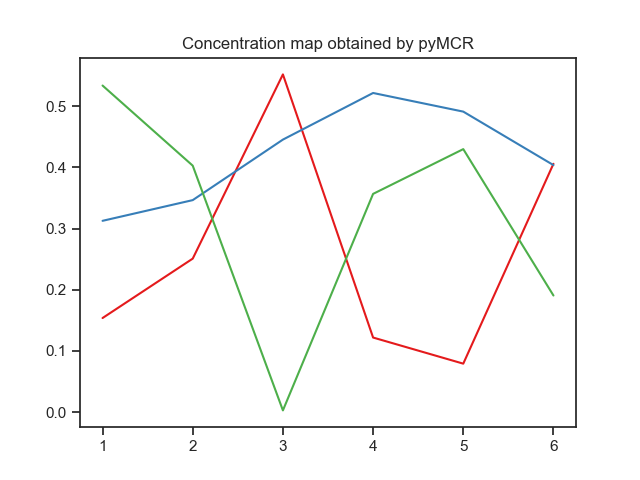

In [19]:
# Create MCR Object
test_mcr = MCR_ALS(D, fit_params, experiment_params)

# Initialize according to FLAGS mentioned above
test_mcr.initialize()
test_mcr.visualize_initial_guesses()

In [20]:
test_mcr.process_MCR(constraints=fit_constraints)

Iter: 1 (ST)	mse: 1.6118e-04
Iter: 1 (ST)	mse: 1.6118e-04
Iter: 2 (C)	mse: 4.2278e-05
Iter: 2 (C)	mse: 4.2278e-05
Iter: 2 (ST)	mse: 2.6856e-05
Iter: 2 (ST)	mse: 2.6856e-05
Iter: 3 (C)	mse: 2.5244e-05
Iter: 3 (C)	mse: 2.5244e-05
Iter: 3 (ST)	mse: 2.4930e-05
Iter: 3 (ST)	mse: 2.4930e-05
Iter: 4 (C)	mse: 2.4877e-05


Iter: 4 (C)	mse: 2.4877e-05
Iter: 4 (ST)	mse: 2.4864e-05
Iter: 4 (ST)	mse: 2.4864e-05
Iter: 5 (C)	mse: 2.4868e-05
Iter: 5 (C)	mse: 2.4868e-05
Iter: 5 (ST)	mse: 2.4867e-05
Iter: 5 (ST)	mse: 2.4867e-05
Iter: 6 (C)	mse: 2.4869e-05
Iter: 6 (C)	mse: 2.4869e-05
Iter: 6 (ST)	mse: 2.4868e-05
Iter: 6 (ST)	mse: 2.4868e-05
Iter: 7 (C)	mse: 2.4869e-05
Iter: 7 (C)	mse: 2.4869e-05
Iter: 7 (ST)	mse: 2.4868e-05
Iter: 7 (ST)	mse: 2.4868e-05
Iter: 8 (C)	mse: 2.4869e-05
Iter: 8 (C)	mse: 2.4869e-05
Iter: 8 (ST)	mse: 2.4869e-05
Iter: 8 (ST)	mse: 2.4869e-05
Iter: 9 (C)	mse: 2.4869e-05
Iter: 9 (C)	mse: 2.4869e-05
Iter: 9 (ST)	mse: 2.4869e-05
Iter: 9 (ST)	mse: 2.4869e-05
Half-iterated 11 times since min error. Exiting.
Half-iterated 11 times since min error. Exiting.

Final MSE: 2.4868584e-05


## Visualize MCR Output

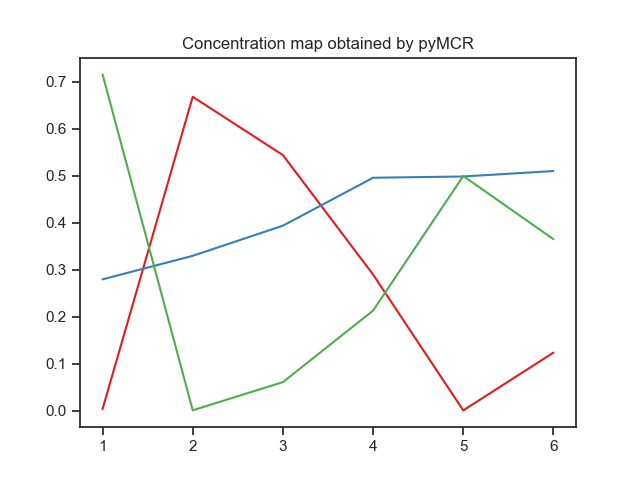

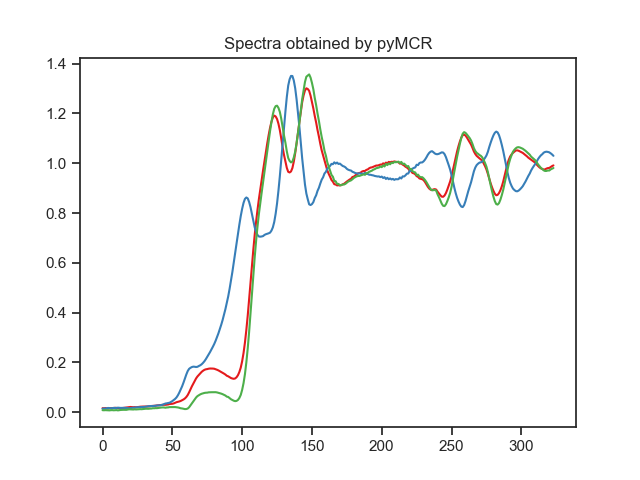

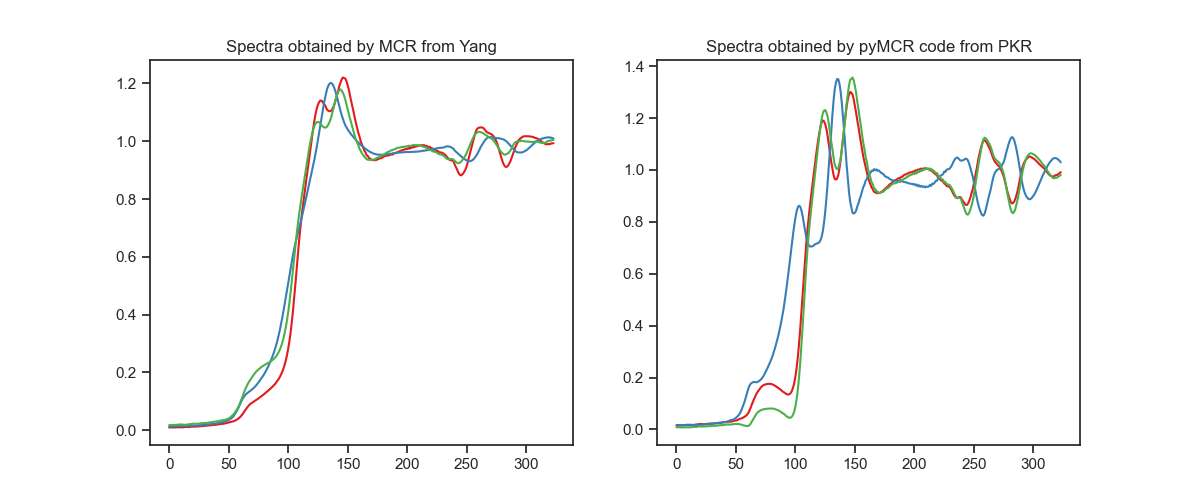

In [21]:
test_mcr.visualize_mcr_output()
test_mcr.compare_output()